In [17]:
import kagglehub

path = kagglehub.dataset_download("mimdim/processed-rice-varieties-of-bangladesh")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/processed-rice-varieties-of-bangladesh


Aush: Attempting RGBe to RGB conversion.
BR-28: Attempting RGBe to RGB conversion.
BR-29: Attempting RGBe to RGB conversion.
Beroi: Attempting RGBe to RGB conversion.
Chinigura: Attempting RGBe to RGB conversion.
Ghee Bhog: Attempting RGBe to RGB conversion.
Katari Najir: Attempting RGBe to RGB conversion.
Katari Siddho: Attempting RGBe to RGB conversion.
Miniket: Attempting RGBe to RGB conversion.
Swarna: Attempting RGBe to RGB conversion.


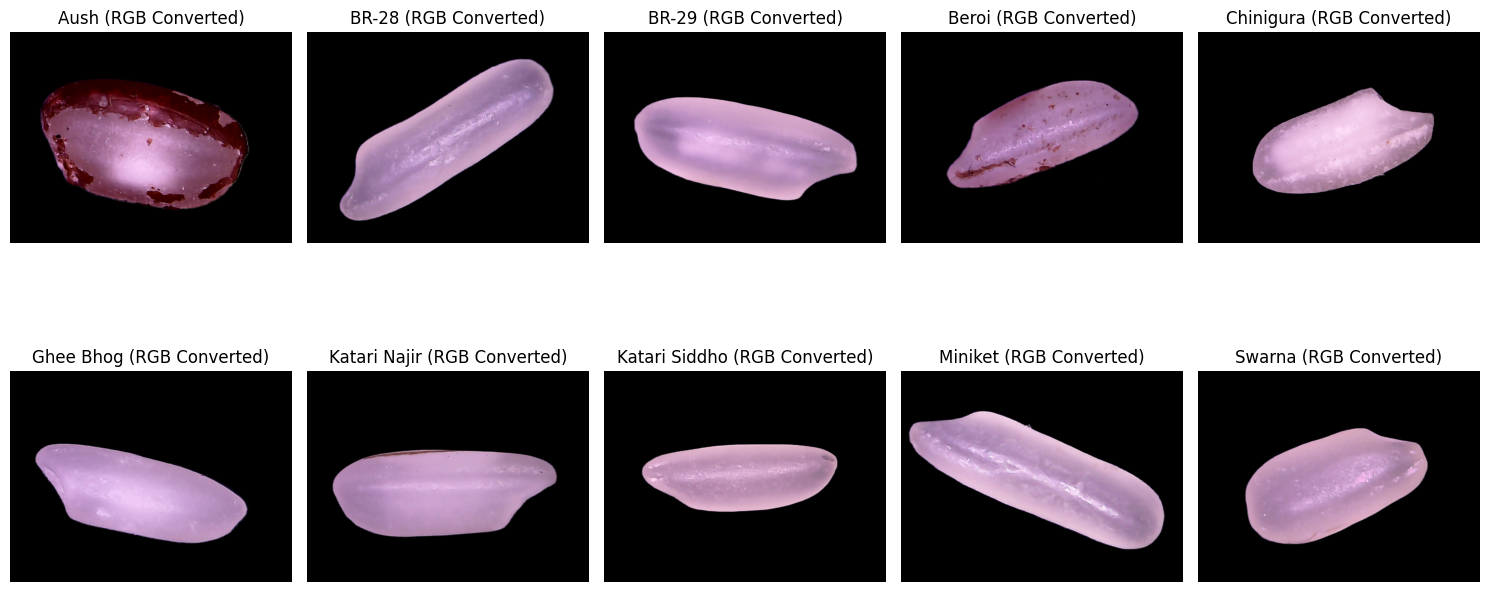

In [18]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

# Function: RGBe → RGB (smooth, non-binary)
def rgbe_to_rgb(img):
    """Converts a 4-channel RGBe image to smooth RGB (0-255)."""
    if img is None or img.ndim != 3 or img.shape[2] != 4:
        print("Warning: Input is not a valid 4-channel image for RGBe conversion.")
        return None

    r, g, b, e = cv2.split(img.astype(np.float32))
    scale = np.exp2(e - 128.0)
    rgb = np.stack([(r / 255) * scale, (g / 255) * scale, (b / 255) * scale], axis=-1)

    # Normalize to 0-255 without binary mapping
    rgb_min, rgb_max = rgb.min(), rgb.max()
    if rgb_max - rgb_min > 0:
        rgb = (rgb - rgb_min) / (rgb_max - rgb_min)
    else:
        rgb = np.zeros_like(rgb)
    rgb = (rgb * 255).astype(np.uint8)

    return rgb

# Folder paths
dataset_dir = "/kaggle/input/processed-rice-varieties-of-bangladesh/PRBD Microscopic Image of Different Processed Rice/Original_Images"

if not os.path.exists(dataset_dir):
    print(f"Error: Dataset directory not found at {dataset_dir}. Please ensure the dataset is downloaded and extracted correctly.")
else:
    classes = sorted(os.listdir(dataset_dir))

    plt.figure(figsize=(15, 8))

    for i, cls in enumerate(classes):
        class_path = os.path.join(dataset_dir, cls)

        if not os.path.isdir(class_path):
            print(f"Skipping {cls}: Not a directory.")
            continue

        image_files = [f for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

        if not image_files:
            print(f"{cls}: No image files found, skipping.")
            continue

        img_path = os.path.join(class_path, image_files[0])
        img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)

        img_to_display = None
        title_text = cls

        if img is not None and isinstance(img, np.ndarray):
            if img.ndim == 3:  # Color images
                if img.shape[2] == 4:  # RGBe
                    print(f"{cls}: Attempting RGBe to RGB conversion.")
                    img_rgb = rgbe_to_rgb(img)
                    if img_rgb is not None:
                        img_to_display = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2RGB)
                        title_text += " (RGB Converted)"
                    else:
                        print(f"{cls}: Failed RGBe to RGB conversion.")
                elif img.shape[2] == 3:  # Normal RGB
                    print(f"{cls}: Normal RGB image, using directly.")
                    img_to_display = cv2.cvtColor(img.astype(np.uint8), cv2.COLOR_BGR2RGB)
                    title_text += " (Original RGB)"
                else:
                    print(f"{cls}: Unsupported number of channels ({img.shape[2]}), skipping.")
            elif img.ndim == 2:  # Grayscale
                print(f"{cls}: Grayscale image, skipping for visualization.")
            else:
                print(f"{cls}: Unsupported number of dimensions ({img.ndim}), skipping.")
        else:
            print(f"{cls}: Could not load image at {img_path} or it is not a valid numpy array, skipping.")

        # Plotting
        plt.subplot(2, (len(classes) + 1) // 2, i + 1)
        if img_to_display is not None:
            plt.imshow(img_to_display)
            plt.title(title_text)
        else:
            plt.text(0.5, 0.5, "Image Skipped", horizontalalignment='center', verticalalignment='center')
            plt.title(title_text + " (Skipped)")
        plt.axis('off')

    plt.tight_layout()
    plt.show()


In [19]:
import os
import shutil
import numpy as np


# Paths

dataset_dir = "/kaggle/input/processed-rice-varieties-of-bangladesh/PRBD Microscopic Image of Different Processed Rice/Original_Images"
split_base_dir = '/kaggle/working/split_data'

# Prepare directories

classes = [d for d in os.listdir(dataset_dir) if os.path.isdir(os.path.join(dataset_dir, d))]
splits = ['train', 'val', 'test']

if os.path.exists(split_base_dir):
    shutil.rmtree(split_base_dir)

for split in splits:
    for cls in classes:
        os.makedirs(os.path.join(split_base_dir, split, cls), exist_ok=True)

# Perform split
for cls in classes:
    class_dir = os.path.join(dataset_dir, cls)
    images = sorted(os.listdir(class_dir))
    np.random.shuffle(images)

    total = len(images)

    # Step 1: 40:60 train:test
    train_val_end = int(total * 0.4)
    train_val_images = images[:train_val_end]
    test_images = images[train_val_end:]

    # Step 2: Within training portion, 10% for validation
    val_end = int(len(train_val_images) * 0.1)
    val_images = train_val_images[:val_end]
    train_images = train_val_images[val_end:]

    # Mapping
    split_images = {
        'train': train_images,
        'val': val_images,
        'test': test_images
    }

    # Copy images
    for split in splits:
        for img_name in split_images[split]:
            src = os.path.join(class_dir, img_name)
            dst = os.path.join(split_base_dir, split, cls, img_name)
            shutil.copy(src, dst)

# Print split summary

print("Dataset Split Summary (number of images per class):\n")
for split in splits:
    print(f"--- {split.upper()} ---")
    for cls in classes:
        split_cls_dir = os.path.join(split_base_dir, split, cls)
        count = len(os.listdir(split_cls_dir))
        print(f"{cls}: {count}")
    print()


Dataset Split Summary (number of images per class):

--- TRAIN ---
Swarna: 72
Katari Siddho: 72
Beroi: 72
BR-29: 72
Katari Najir: 72
Miniket: 72
Chinigura: 72
Ghee Bhog: 72
BR-28: 72
Aush: 72

--- VAL ---
Swarna: 8
Katari Siddho: 8
Beroi: 8
BR-29: 8
Katari Najir: 8
Miniket: 8
Chinigura: 8
Ghee Bhog: 8
BR-28: 8
Aush: 8

--- TEST ---
Swarna: 120
Katari Siddho: 120
Beroi: 120
BR-29: 120
Katari Najir: 120
Miniket: 120
Chinigura: 120
Ghee Bhog: 120
BR-28: 120
Aush: 120



Found 720 images belonging to 10 classes.
Found 80 images belonging to 10 classes.
Found 1200 images belonging to 10 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
23/23 - 73s - 3s/step - accuracy: 0.4653 - loss: 1.5523 - val_accuracy: 0.8000 - val_loss: 0.8141 - learning_rate: 0.0010
Epoch 2/50
23/23 - 6s - 262ms/step - accuracy: 0.7250 - loss: 0.8309 - val_accuracy: 0.8750 - val_loss: 0.5713 - learning_rate: 0.0010
Epoch 3/50
23/23 - 6s - 255ms/step - accuracy: 0.7569 - loss: 0.6763 - val_accuracy: 0.8750 - val_loss: 0.4987 - learning_rate: 0.0010
Epoch 4/50
23/23 - 6s - 253ms/step - accuracy: 0.8181 - loss: 0.5788 - val_accuracy: 0.8875 - val_loss: 0.4361 - learning_rate: 0.0010
Epoch 5/50
23/23 - 6s - 249ms/step - accuracy: 0.8472 - loss: 0.4965 - val_accuracy: 0.8375 - val_loss: 0.4649 - learning_rate: 0.0010
Epoch 6/50
23/23 - 6s - 254ms/step - accuracy: 0.8681 - loss: 0.4551 - val_accuracy: 0.9250 - val_loss: 0.4259 - learning_rate: 0.0010
Epoch 7/50
23/23 - 6s - 254ms/step - accuracy: 0.8556 - loss: 0.4527 - val_accuracy: 0.8750 - val_loss: 0.4503 - learning_rate: 0.0010
Epoch 8/50
23/23 - 6s - 250ms/step - accuracy: 0.8819 - l

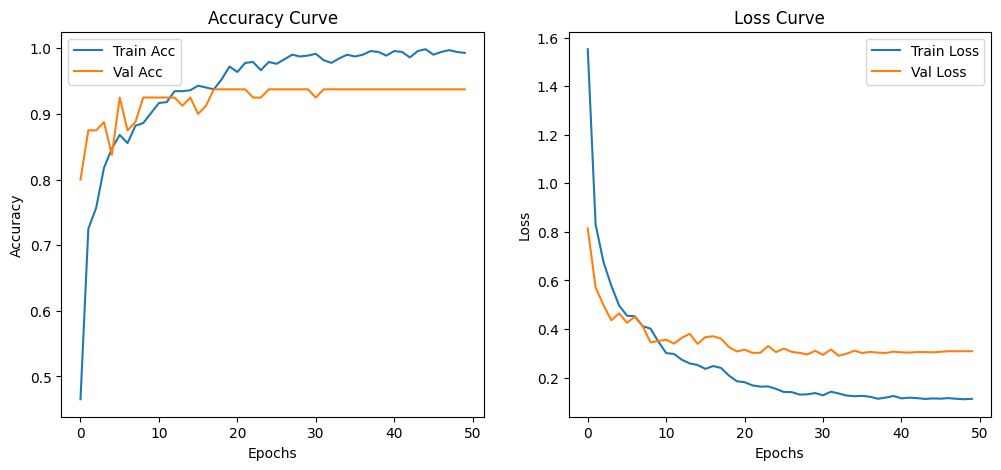


Test Classification Report:
               precision    recall  f1-score   support

       Swarna     0.9748    0.9667    0.9707       120
Katari Siddho     0.7656    0.8167    0.7903       120
        Beroi     0.8649    0.8000    0.8312       120
        BR-29     0.9831    0.9667    0.9748       120
 Katari Najir     0.9675    0.9917    0.9794       120
      Miniket     0.8413    0.8833    0.8618       120
    Chinigura     0.8197    0.8333    0.8264       120
    Ghee Bhog     0.8305    0.8167    0.8235       120
        BR-28     0.9417    0.9417    0.9417       120
         Aush     0.8870    0.8500    0.8681       120

     accuracy                         0.8867      1200
    macro avg     0.8876    0.8867    0.8868      1200
 weighted avg     0.8876    0.8867    0.8868      1200



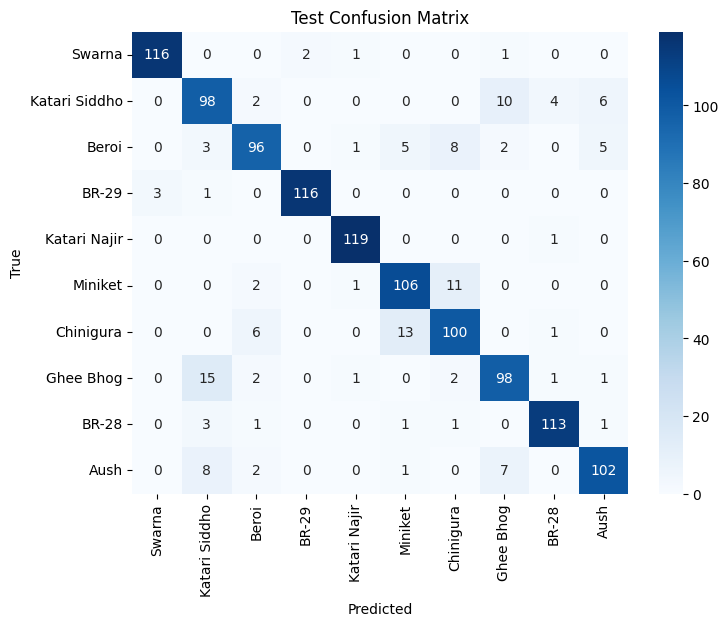

Swarna Accuracy: 0.9667
Katari Siddho Accuracy: 0.8167
Beroi Accuracy: 0.8000
BR-29 Accuracy: 0.9667
Katari Najir Accuracy: 0.9917
Miniket Accuracy: 0.8833
Chinigura Accuracy: 0.8333
Ghee Bhog Accuracy: 0.8167
BR-28 Accuracy: 0.9417
Aush Accuracy: 0.8500
Test AUC: 0.9900
Test PR AUC: 0.9363

Training Time: 361.31 seconds


In [20]:
import os
import time
import numpy as np
import tensorflow as tf
from sklearn.metrics import classification_report, roc_auc_score, average_precision_score, confusion_matrix
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications import NASNetMobile
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau
import matplotlib.pyplot as plt
import seaborn as sns

# Paths and parameters

split_base_dir = '/kaggle/working/split_data'
img_size = (224, 224)
batch_size = 32
num_classes = 10
classes = [d for d in os.listdir(dataset_dir) if os.path.isdir(os.path.join(dataset_dir, d))]


# Data generators
# -----------------------------
datagen = ImageDataGenerator(rescale=1./255)

train_gen = datagen.flow_from_directory(
    os.path.join(split_base_dir, 'train'),
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

val_gen = datagen.flow_from_directory(
    os.path.join(split_base_dir, 'val'),
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

test_gen = datagen.flow_from_directory(
    os.path.join(split_base_dir, 'test'),
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# -----------------------------
# Model: NASNetMobile
# -----------------------------
def build_nasnetmobile_model(input_shape=(224,224,3), num_classes=10, dropout_rate=0.3, l2_reg=1e-4):
    base_model = NASNetMobile(include_top=False, weights='imagenet', input_shape=input_shape)
    base_model.trainable = False  # freeze backbone
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu', kernel_regularizer=l2(l2_reg))(x)
    x = Dropout(dropout_rate)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=outputs)
    return model

nasnet_model = build_nasnetmobile_model(num_classes=num_classes)
nasnet_model.compile(optimizer=tf.keras.optimizers.Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# -----------------------------
# Callback (only LR scheduler, no early stop)
# -----------------------------
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

# -----------------------------
# Training (50 epochs, no early stop)
# -----------------------------
start_time = time.time()
history = nasnet_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=50,
    callbacks=[reduce_lr],
    verbose=2
)
training_time = time.time() - start_time

# -----------------------------
# Plot training curves
# -----------------------------
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# -----------------------------
# Evaluation function
# -----------------------------
def evaluate_model(generator, model):
    steps = int(np.ceil(generator.samples / generator.batch_size))
    y_true = []
    y_pred_prob = []
    for _ in range(steps):
        x_batch, y_batch = next(generator)
        preds = model.predict(x_batch, verbose=0)
        y_true.append(y_batch)
        y_pred_prob.append(preds)
    y_true = np.vstack(y_true)
    y_pred_prob = np.vstack(y_pred_prob)
    y_pred = np.argmax(y_pred_prob, axis=1)
    y_true_labels = np.argmax(y_true, axis=1)
    return y_true_labels, y_pred, y_true, y_pred_prob

train_true, train_pred, train_true_prob, train_pred_prob = evaluate_model(train_gen, nasnet_model)
val_true, val_pred, val_true_prob, val_pred_prob = evaluate_model(val_gen, nasnet_model)
test_true, test_pred, test_true_prob, test_pred_prob = evaluate_model(test_gen, nasnet_model)

# -----------------------------
# Reports
# -----------------------------
print("\nTest Classification Report:")
print(classification_report(test_true, test_pred, digits=4, target_names=classes))

cm = confusion_matrix(test_true, test_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=classes, yticklabels=classes, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Test Confusion Matrix')
plt.show()

# Per-class accuracy
per_class_acc = cm.diagonal() / cm.sum(axis=1)
for cls, acc in zip(classes, per_class_acc):
    print(f"{cls} Accuracy: {acc:.4f}")

# AUC & PR
print(f"Test AUC: {roc_auc_score(test_true_prob, test_pred_prob, average='macro', multi_class='ovr'):.4f}")
print(f"Test PR AUC: {average_precision_score(test_true_prob, test_pred_prob, average='macro'):.4f}")

print(f"\nTraining Time: {training_time:.2f} seconds")

Macro Precision: 0.8876
Macro Recall: 0.8867
Macro F1-score: 0.8868
Swarna: Precision=0.9748, Recall=0.9667, F1=0.9707
Katari Siddho: Precision=0.7656, Recall=0.8167, F1=0.7903
Beroi: Precision=0.8649, Recall=0.8000, F1=0.8312
BR-29: Precision=0.9831, Recall=0.9667, F1=0.9748
Katari Najir: Precision=0.9675, Recall=0.9917, F1=0.9794
Miniket: Precision=0.8413, Recall=0.8833, F1=0.8618
Chinigura: Precision=0.8197, Recall=0.8333, F1=0.8264
Ghee Bhog: Precision=0.8305, Recall=0.8167, F1=0.8235
BR-28: Precision=0.9417, Recall=0.9417, F1=0.9417
Aush: Precision=0.8870, Recall=0.8500, F1=0.8681


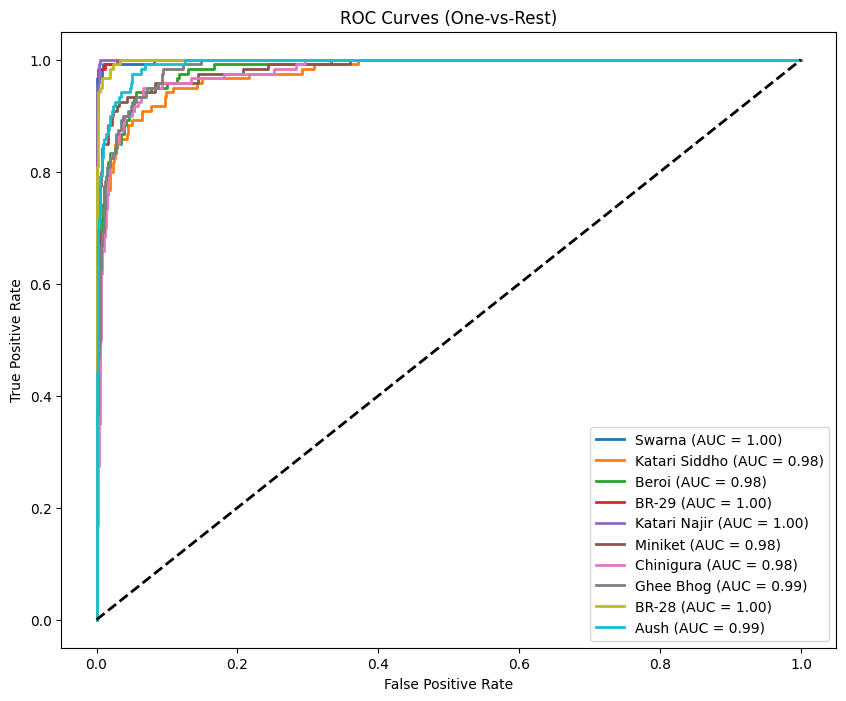

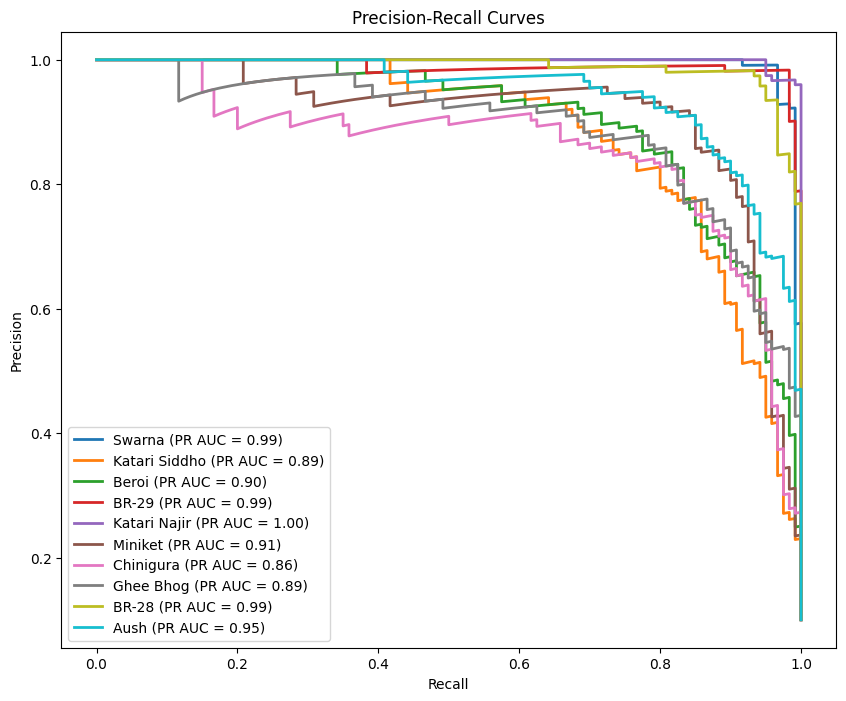

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Total inference time: 36.93 sec
Inference time per sample: 0.030778 sec

Most confused class pairs:
Swarna is most often confused with BR-29 (2 samples)
Katari Siddho is most often confused with Ghee Bhog (10 samples)
Beroi is most often confused with Chinigura (8 samples)
BR-29 is most often confused with Swarna (3 samples)
Katari Najir is most often confused with BR-28 (1 samples)
Miniket is most often confused with Chinigura (11 samples)
Chinigura is most often confused with Miniket (13 samples)
Ghee Bhog is most often confused with Katari Siddho (15 samples)
BR-28 is most often confused with Katari Siddho (3 samples)
Aush is most often confused with Katari Siddho (8 samples)


In [21]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, auc, average_precision_score, precision_recall_curve, confusion_matrix
from sklearn.preprocessing import label_binarize
import tensorflow as tf
from tensorflow.keras.applications import NASNetMobile

# -----------------------------
# Assume you already have:
# test_true: true labels (as integers)
# test_pred_prob: predicted probabilities from model.predict
# test_pred: predicted class labels (argmax of test_pred_prob)
# classes: list of class names
# num_classes: total number of classes
# -----------------------------

# -----------------------------
# Macro metrics
# -----------------------------
macro_precision = precision_score(test_true, test_pred, average='macro', zero_division=0)
macro_recall = recall_score(test_true, test_pred, average='macro', zero_division=0)
macro_f1 = f1_score(test_true, test_pred, average='macro', zero_division=0)

print(f"Macro Precision: {macro_precision:.4f}")
print(f"Macro Recall: {macro_recall:.4f}")
print(f"Macro F1-score: {macro_f1:.4f}")

# -----------------------------
# Per-class metrics
# -----------------------------
per_class_precision = precision_score(test_true, test_pred, average=None, zero_division=0)
per_class_recall = recall_score(test_true, test_pred, average=None, zero_division=0)
per_class_f1 = f1_score(test_true, test_pred, average=None, zero_division=0)

for i, cls in enumerate(classes):
    print(f"{cls}: Precision={per_class_precision[i]:.4f}, Recall={per_class_recall[i]:.4f}, F1={per_class_f1[i]:.4f}")

# -----------------------------
# ROC–AUC curves (One-vs-Rest)
# -----------------------------
y_true_bin = label_binarize(test_true, classes=range(num_classes))

plt.figure(figsize=(10,8))
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], test_pred_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{classes[i]} (AUC = {roc_auc:.2f})')

plt.plot([0,1],[0,1],'k--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves (One-vs-Rest)')
plt.legend(loc='lower right')
plt.show()

# -----------------------------
# Precision-Recall curves
# -----------------------------
plt.figure(figsize=(10,8))
for i in range(num_classes):
    precision_vals, recall_vals, _ = precision_recall_curve(y_true_bin[:, i], test_pred_prob[:, i])
    pr_auc = auc(recall_vals, precision_vals)
    plt.plot(recall_vals, precision_vals, lw=2, label=f'{classes[i]} (PR AUC = {pr_auc:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.legend(loc='lower left')
plt.show()

# -----------------------------
# Inference time per sample
# -----------------------------
nasnet_model = NASNetMobile(weights='imagenet', include_top=False)  # dummy, replace with your trained model
start_infer = time.time()
_ = nasnet_model.predict(test_gen, verbose=0)  # test_gen = your test generator
total_infer_time = time.time() - start_infer
time_per_sample = total_infer_time / test_gen.samples
print(f"Total inference time: {total_infer_time:.2f} sec")
print(f"Inference time per sample: {time_per_sample:.6f} sec")

# -----------------------------
# Most confused class pairs
# -----------------------------
cm_df = pd.DataFrame(confusion_matrix(test_true, test_pred), index=classes, columns=classes)

print("\nMost confused class pairs:")
for cls in classes:
    row = cm_df.loc[cls].copy()
    row[cls] = 0  # ignore correct predictions
    most_confused = row.idxmax()
    print(f"{cls} is most often confused with {most_confused} ({row.max()} samples)")


In [22]:
start_test = time.time()
_ = nasnet_model.predict(test_gen, verbose=0)
inference_time = time.time() - start_test
samples = test_gen.samples
print(f"Inference Time per sample: {inference_time/samples:.6f} seconds")


Inference Time per sample: 0.007775 seconds


In [23]:
# -----------------------------
# Model parameters
# -----------------------------
total_params = nasnet_model.count_params()
trainable_params = np.sum([tf.keras.backend.count_params(w) for w in nasnet_model.trainable_weights])
non_trainable_params = np.sum([tf.keras.backend.count_params(w) for w in nasnet_model.non_trainable_weights])

print(f"\nTotal Parameters: {total_params:,}")
print(f"Trainable Parameters: {trainable_params:,}")
print(f"Non-Trainable Parameters: {non_trainable_params:,}")


Total Parameters: 4,269,716
Trainable Parameters: 4,232,978
Non-Trainable Parameters: 36,738


Found 650 images belonging to 10 classes.
Found 70 images belonging to 10 classes.
Found 1200 images belonging to 10 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
21/21 - 38s - 2s/step - accuracy: 0.3385 - loss: 1.9602 - val_accuracy: 0.5143 - val_loss: 1.4536 - learning_rate: 0.0010
Epoch 2/50
21/21 - 13s - 630ms/step - accuracy: 0.5815 - loss: 1.2776 - val_accuracy: 0.5714 - val_loss: 1.1435 - learning_rate: 0.0010
Epoch 3/50
21/21 - 13s - 627ms/step - accuracy: 0.6815 - loss: 0.9883 - val_accuracy: 0.7000 - val_loss: 0.9259 - learning_rate: 0.0010
Epoch 4/50
21/21 - 13s - 625ms/step - accuracy: 0.6985 - loss: 0.8966 - val_accuracy: 0.7143 - val_loss: 0.9192 - learning_rate: 0.0010
Epoch 5/50
21/21 - 13s - 617ms/step - accuracy: 0.7600 - loss: 0.7875 - val_accuracy: 0.7286 - val_loss: 0.8595 - learning_rate: 0.0010
Epoch 6/50
21/21 - 13s - 598ms/step - accuracy: 0.7923 - loss: 0.7066 - val_accuracy: 0.7143 - val_loss: 0.8377 - learning_rate: 0.0010
Epoch 7/50
21/21 - 13s - 621ms/step - accuracy: 0.8046 - loss: 0.6537 - val_accuracy: 0.8714 - val_loss: 0.6664 - learning_rate: 0.0010
Epoch 8/50
21/21 - 12s - 593ms/step - accuracy: 0.8

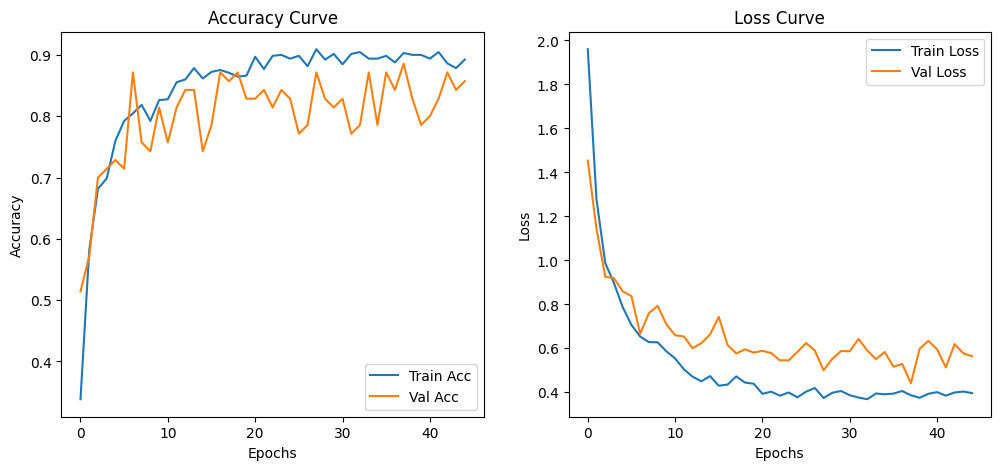


Test Classification Report:
               precision    recall  f1-score   support

       Swarna     0.9750    0.9750    0.9750       120
Katari Siddho     0.6456    0.8500    0.7338       120
        Beroi     0.8065    0.8333    0.8197       120
        BR-29     0.9826    0.9417    0.9617       120
 Katari Najir     0.9916    0.9833    0.9874       120
      Miniket     0.7516    0.9833    0.8520       120
    Chinigura     0.9718    0.5750    0.7225       120
    Ghee Bhog     0.7534    0.9167    0.8271       120
        BR-28     0.9904    0.8583    0.9196       120
         Aush     0.9535    0.6833    0.7961       120

     accuracy                         0.8600      1200
    macro avg     0.8822    0.8600    0.8595      1200
 weighted avg     0.8822    0.8600    0.8595      1200



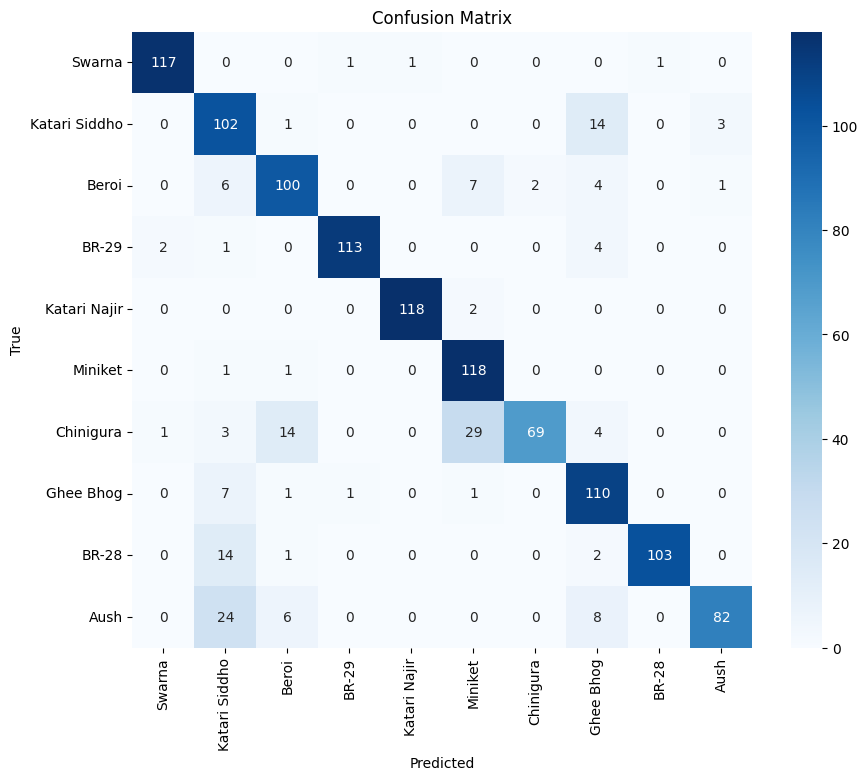

Swarna Accuracy: 0.9750
Katari Siddho Accuracy: 0.8500
Beroi Accuracy: 0.8333
BR-29 Accuracy: 0.9417
Katari Najir Accuracy: 0.9833
Miniket Accuracy: 0.9833
Chinigura Accuracy: 0.5750
Ghee Bhog Accuracy: 0.9167
BR-28 Accuracy: 0.8583
Aush Accuracy: 0.6833
Test AUC: 0.9922
Test PR AUC: 0.9487

Total Training Time: 468.55 seconds


In [25]:
import os
import time
import numpy as np
import tensorflow as tf
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, roc_auc_score, average_precision_score, confusion_matrix
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications import ConvNeXtTiny
from tensorflow.keras.applications.convnext import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import matplotlib.pyplot as plt
import seaborn as sns

# -----------------------------
# Paths and parameters
# -----------------------------
dataset_dir = "/kaggle/input/processed-rice-varieties-of-bangladesh/PRBD Microscopic Image of Different Processed Rice/Original_Images"
split_base_dir = '/kaggle/working/split_data'
img_size = (224, 224)
batch_size = 32
num_classes = 10
classes = [d for d in os.listdir(dataset_dir) if os.path.isdir(os.path.join(dataset_dir, d))]

# -----------------------------
# Data Generators with Augmentation
# -----------------------------
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8,1.2],
    validation_split=0.1  # 10% validation from 20% train+val
)

train_gen = train_datagen.flow_from_directory(
    split_base_dir+'/train',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    subset='training'
)

val_gen = train_datagen.flow_from_directory(
    split_base_dir+'/train',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False,
    subset='validation'
)

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_gen = test_datagen.flow_from_directory(
    split_base_dir+'/test',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# -----------------------------
# Compute class weights
# -----------------------------
train_labels = train_gen.classes
class_weights = compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)
class_weights_dict = {i: w for i, w in enumerate(class_weights)}

# -----------------------------
# Build ConvNeXtTiny model
# -----------------------------
def build_convnext_model(input_shape=(224,224,3), num_classes=10, dropout_rate=0.3, l2_reg=1e-4):
    base_model = ConvNeXtTiny(include_top=False, weights='imagenet', input_shape=input_shape)
    base_model.trainable = False  # Freeze backbone initially
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu', kernel_regularizer=l2(l2_reg))(x)
    x = Dropout(dropout_rate)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=outputs)
    return model

convnext_model = build_convnext_model(num_classes=num_classes)
convnext_model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# -----------------------------
# Callbacks
# -----------------------------
early_stop = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)
checkpoint = ModelCheckpoint('best_convnext_model.h5', save_best_only=True, monitor='val_accuracy', mode='max')

# -----------------------------
# Training (Frozen backbone) - 50 epochs
# -----------------------------
start_time = time.time()
history = convnext_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=50,   # 50 epochs frozen
    class_weight=class_weights_dict,
    callbacks=[early_stop, reduce_lr, checkpoint],
    verbose=2
)
training_time = time.time() - start_time

# -----------------------------
# Fine-tuning (last 20 layers)
# -----------------------------
convnext_model.trainable = True
for layer in convnext_model.layers[:-20]:
    layer.trainable = False

convnext_model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_ft = convnext_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,   # fine-tuning for 10 epochs
    class_weight=class_weights_dict,
    callbacks=[early_stop, reduce_lr, checkpoint],
    verbose=2
)

# -----------------------------
# Plot training curves
# -----------------------------
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'] + history_ft.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'] + history_ft.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'] + history_ft.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'] + history_ft.history['val_loss'], label='Val Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# -----------------------------
# Evaluation
# -----------------------------
def evaluate_model(generator, model):
    steps = int(np.ceil(generator.samples / generator.batch_size))
    y_true = []
    y_pred_prob = []
    for _ in range(steps):
        x_batch, y_batch = next(generator)
        preds = model.predict(x_batch, verbose=0)
        y_true.append(y_batch)
        y_pred_prob.append(preds)
    y_true = np.vstack(y_true)
    y_pred_prob = np.vstack(y_pred_prob)
    y_pred = np.argmax(y_pred_prob, axis=1)
    y_true_labels = np.argmax(y_true, axis=1)
    return y_true_labels, y_pred, y_true, y_pred_prob

train_true, train_pred, train_true_prob, train_pred_prob = evaluate_model(train_gen, convnext_model)
val_true, val_pred, val_true_prob, val_pred_prob = evaluate_model(val_gen, convnext_model)
test_true, test_pred, test_true_prob, test_pred_prob = evaluate_model(test_gen, convnext_model)

print("\nTest Classification Report:")
print(classification_report(test_true, test_pred, digits=4, target_names=classes))

cm = confusion_matrix(test_true, test_pred)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=classes, yticklabels=classes, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

per_class_acc = cm.diagonal() / cm.sum(axis=1)
for cls, acc in zip(classes, per_class_acc):
    print(f"{cls} Accuracy: {acc:.4f}")

print(f"Test AUC: {roc_auc_score(test_true_prob, test_pred_prob, average='macro', multi_class='ovr'):.4f}")
print(f"Test PR AUC: {average_precision_score(test_true_prob, test_pred_prob, average='macro'):.4f}")

print(f"\nTotal Training Time: {training_time:.2f} seconds")


Macro Precision: 0.8822
Macro Recall: 0.8600
Macro F1-score: 0.8595
Swarna: Precision=0.9750, Recall=0.9750, F1=0.9750
Katari Siddho: Precision=0.6456, Recall=0.8500, F1=0.7338
Beroi: Precision=0.8065, Recall=0.8333, F1=0.8197
BR-29: Precision=0.9826, Recall=0.9417, F1=0.9617
Katari Najir: Precision=0.9916, Recall=0.9833, F1=0.9874
Miniket: Precision=0.7516, Recall=0.9833, F1=0.8520
Chinigura: Precision=0.9718, Recall=0.5750, F1=0.7225
Ghee Bhog: Precision=0.7534, Recall=0.9167, F1=0.8271
BR-28: Precision=0.9904, Recall=0.8583, F1=0.9196
Aush: Precision=0.9535, Recall=0.6833, F1=0.7961


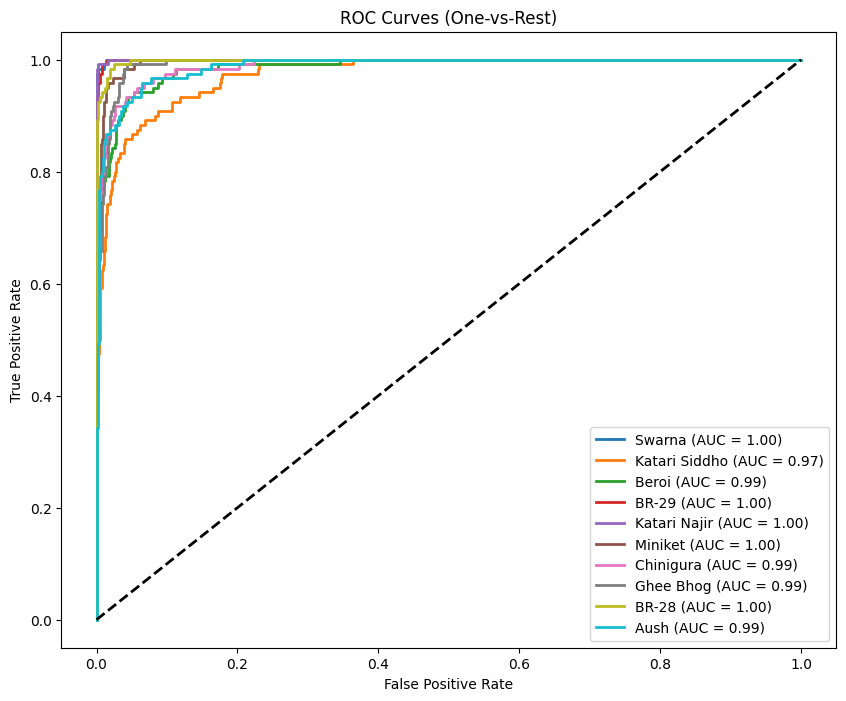

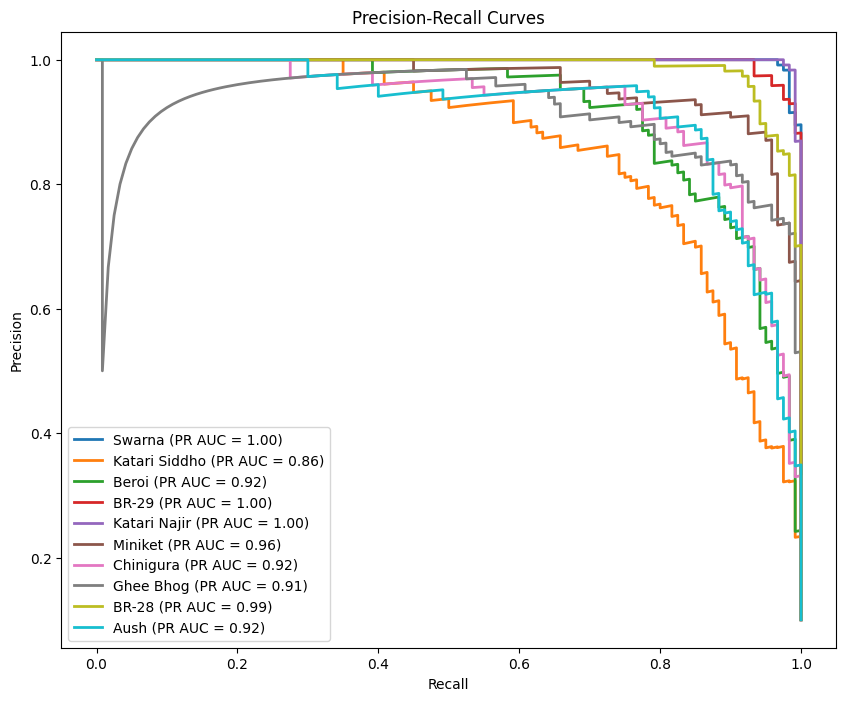


Most confused class pairs:
Swarna is most often confused with BR-29 (1 samples)
Katari Siddho is most often confused with Ghee Bhog (14 samples)
Beroi is most often confused with Miniket (7 samples)
BR-29 is most often confused with Ghee Bhog (4 samples)
Katari Najir is most often confused with Miniket (2 samples)
Miniket is most often confused with Katari Siddho (1 samples)
Chinigura is most often confused with Miniket (29 samples)
Ghee Bhog is most often confused with Katari Siddho (7 samples)
BR-28 is most often confused with Katari Siddho (14 samples)
Aush is most often confused with Katari Siddho (24 samples)


In [27]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, auc, average_precision_score, precision_recall_curve
from sklearn.preprocessing import label_binarize
import pandas as pd
import time
import matplotlib.pyplot as plt

# -----------------------------
# Precision, Recall, F1-score
# -----------------------------
macro_precision = precision_score(test_true, test_pred, average='macro')
macro_recall = recall_score(test_true, test_pred, average='macro')
macro_f1 = f1_score(test_true, test_pred, average='macro')

print(f"Macro Precision: {macro_precision:.4f}")
print(f"Macro Recall: {macro_recall:.4f}")
print(f"Macro F1-score: {macro_f1:.4f}")

# Per-class scores
per_class_precision = precision_score(test_true, test_pred, average=None)
per_class_recall = recall_score(test_true, test_pred, average=None)
per_class_f1 = f1_score(test_true, test_pred, average=None)

for i, cls in enumerate(classes):
    print(f"{cls}: Precision={per_class_precision[i]:.4f}, Recall={per_class_recall[i]:.4f}, F1={per_class_f1[i]:.4f}")

# -----------------------------
# ROC–AUC curves (One-vs-Rest)
# -----------------------------
y_true_bin = label_binarize(test_true, classes=range(num_classes))

plt.figure(figsize=(10,8))
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], test_pred_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{classes[i]} (AUC = {roc_auc:.2f})')

plt.plot([0,1],[0,1],'k--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves (One-vs-Rest)')
plt.legend(loc='lower right')
plt.show()

# -----------------------------
# PR curves
# -----------------------------
plt.figure(figsize=(10,8))
for i in range(num_classes):
    precision_vals, recall_vals, _ = precision_recall_curve(y_true_bin[:, i], test_pred_prob[:, i])
    pr_auc = auc(recall_vals, precision_vals)
    plt.plot(recall_vals, precision_vals, lw=2, label=f'{classes[i]} (PR AUC = {pr_auc:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.legend(loc='lower left')
plt.show()

# Failure modes: most confused class pairs
# -----------------------------
cm_df = pd.DataFrame(confusion_matrix(test_true, test_pred), index=classes, columns=classes)

print("\nMost confused class pairs:")
for cls in classes:
    row = cm_df.loc[cls].copy()
    row[cls] = 0  # ignore correct predictions
    most_confused = row.idxmax()
    print(f"{cls} is most often confused with {most_confused} ({row.max()} samples)")


In [30]:
# Calculate and print the number of parameters
total_params = convnext_model.count_params()
trainable_params = sum([tf.keras.backend.count_params(w) for w in convnext_model.trainable_weights])
non_trainable_params = sum([tf.keras.backend.count_params(w) for w in convnext_model.non_trainable_weights])

print(f"Total Parameters: {total_params:,}")
print(f"Trainable Parameters: {trainable_params:,}")
print(f"Non-Trainable Parameters: {non_trainable_params:,}")

Total Parameters: 28,218,986
Trainable Parameters: 398,858
Non-Trainable Parameters: 27,820,128


Found 720 images belonging to 10 classes.
Found 80 images belonging to 10 classes.
Found 1200 images belonging to 10 classes.
Epoch 1/50
23/23 - 57s - 2s/step - accuracy: 0.4264 - loss: 1.8304 - val_accuracy: 0.7000 - val_loss: 0.8769 - learning_rate: 0.0010
Epoch 2/50
23/23 - 20s - 868ms/step - accuracy: 0.6444 - loss: 1.0393 - val_accuracy: 0.8250 - val_loss: 0.7052 - learning_rate: 0.0010
Epoch 3/50
23/23 - 20s - 878ms/step - accuracy: 0.7000 - loss: 0.8608 - val_accuracy: 0.8625 - val_loss: 0.5584 - learning_rate: 0.0010
Epoch 4/50
23/23 - 20s - 869ms/step - accuracy: 0.7472 - loss: 0.7555 - val_accuracy: 0.8500 - val_loss: 0.6183 - learning_rate: 0.0010
Epoch 5/50
23/23 - 20s - 867ms/step - accuracy: 0.7458 - loss: 0.7855 - val_accuracy: 0.8000 - val_loss: 0.5714 - learning_rate: 0.0010
Epoch 6/50
23/23 - 20s - 880ms/step - accuracy: 0.7500 - loss: 0.7065 - val_accuracy: 0.8125 - val_loss: 0.5365 - learning_rate: 0.0010
Epoch 7/50
23/23 - 20s - 869ms/step - accuracy: 0.8000 - loss

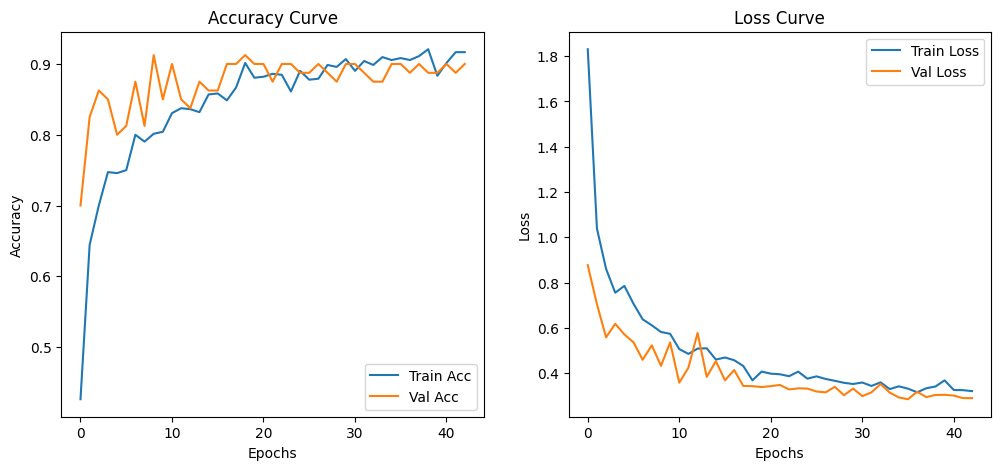


Test Classification Report:
               precision    recall  f1-score   support

       Swarna     0.9832    0.9750    0.9791       120
Katari Siddho     0.6821    0.8583    0.7601       120
        Beroi     0.8760    0.8833    0.8797       120
        BR-29     0.9750    0.9750    0.9750       120
 Katari Najir     0.9916    0.9833    0.9874       120
      Miniket     0.7534    0.9167    0.8271       120
    Chinigura     0.8485    0.7000    0.7671       120
    Ghee Bhog     0.8673    0.8167    0.8412       120
        BR-28     0.9512    0.9750    0.9630       120
         Aush     0.9326    0.6917    0.7943       120

     accuracy                         0.8775      1200
    macro avg     0.8861    0.8775    0.8774      1200
 weighted avg     0.8861    0.8775    0.8774      1200



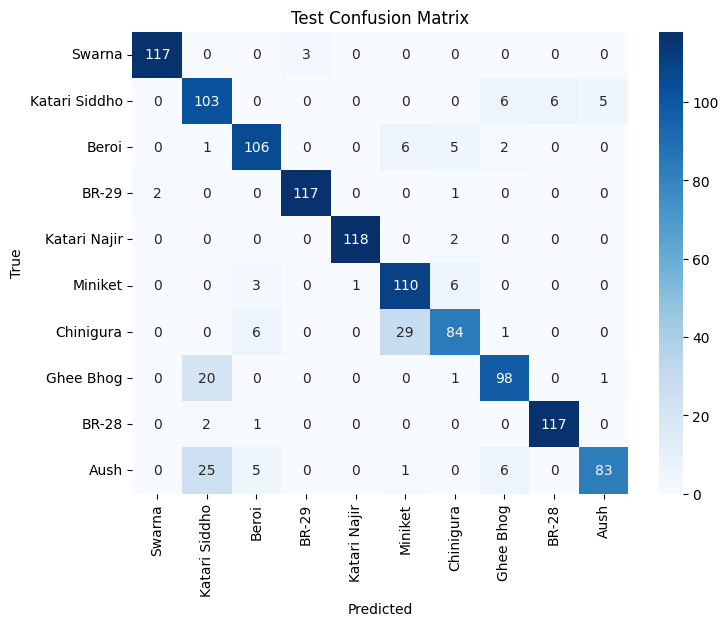

Swarna Accuracy: 0.9750
Katari Siddho Accuracy: 0.8583
Beroi Accuracy: 0.8833
BR-29 Accuracy: 0.9750
Katari Najir Accuracy: 0.9833
Miniket Accuracy: 0.9167
Chinigura Accuracy: 0.7000
Ghee Bhog Accuracy: 0.8167
BR-28 Accuracy: 0.9750
Aush Accuracy: 0.6917
Macro Precision: 0.8861, Macro Recall: 0.8775, Macro F1-score: 0.8774


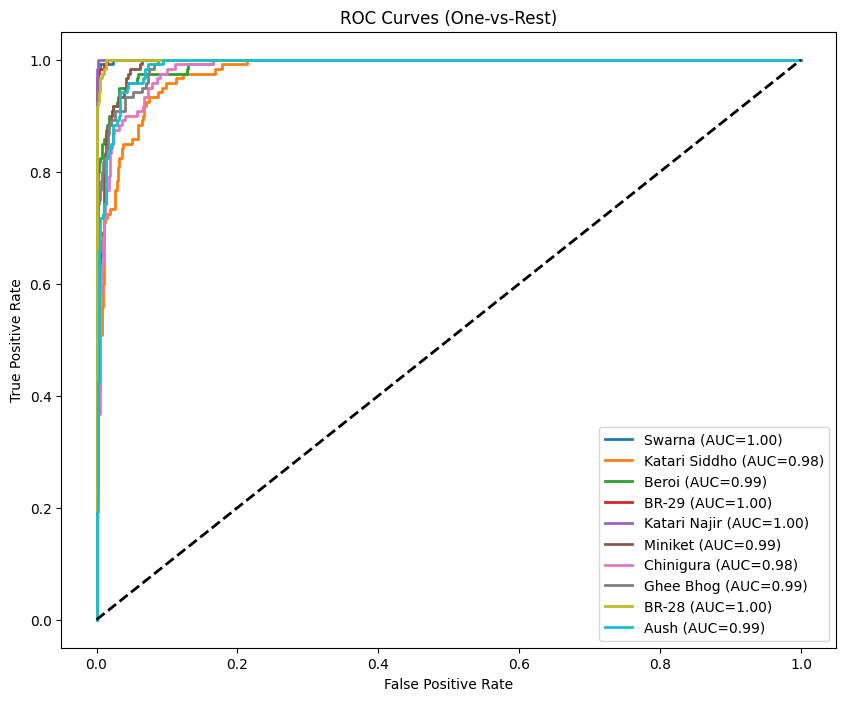

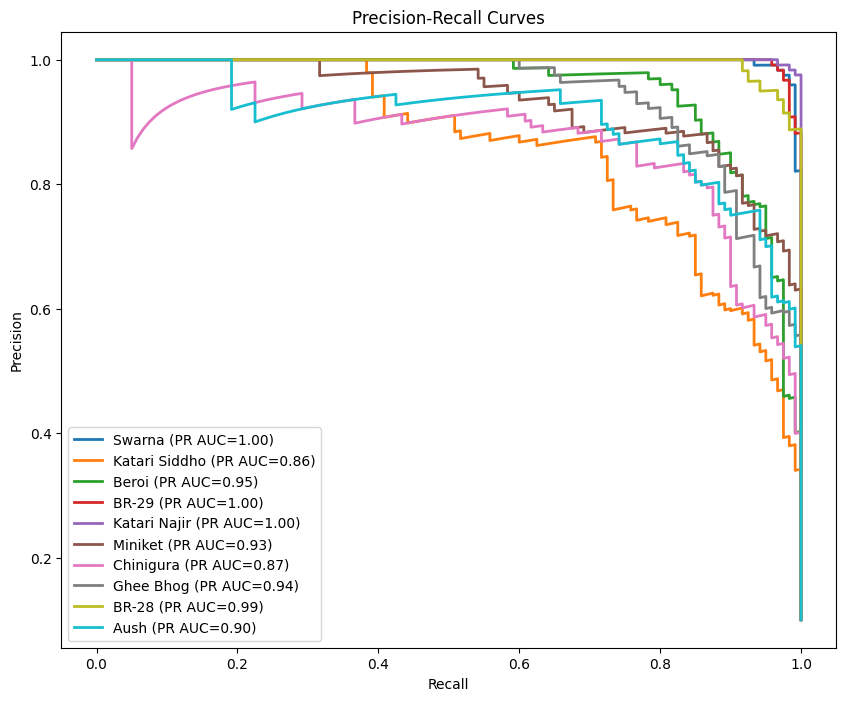


Most confused class pairs:
Swarna is most often confused with BR-29 (3 samples)
Katari Siddho is most often confused with Ghee Bhog (6 samples)
Beroi is most often confused with Miniket (6 samples)
BR-29 is most often confused with Swarna (2 samples)
Katari Najir is most often confused with Chinigura (2 samples)
Miniket is most often confused with Chinigura (6 samples)
Chinigura is most often confused with Miniket (29 samples)
Ghee Bhog is most often confused with Katari Siddho (20 samples)
BR-28 is most often confused with Katari Siddho (2 samples)
Aush is most often confused with Katari Siddho (25 samples)


In [33]:
#Model-3:InceptionV3 

import os
import time
import numpy as np
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score, roc_curve, auc, precision_recall_curve
from sklearn.preprocessing import label_binarize
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# -----------------------------
# Paths and parameters
# -----------------------------
split_base_dir = '/kaggle/working/split_data'
dataset_dir = "/kaggle/input/processed-rice-varieties-of-bangladesh/PRBD Microscopic Image of Different Processed Rice/Original_Images"
img_size = (299, 299)
batch_size = 32
num_classes = 10
classes = [d for d in os.listdir(dataset_dir) if os.path.isdir(os.path.join(dataset_dir, d))]

# -----------------------------
# Data generators with augmentation
# -----------------------------
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2]
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    os.path.join(split_base_dir, 'train'),
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

val_gen = val_test_datagen.flow_from_directory(
    os.path.join(split_base_dir, 'val'),
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

test_gen = val_test_datagen.flow_from_directory(
    os.path.join(split_base_dir, 'test'),
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# -----------------------------
# Build InceptionV3 model
# -----------------------------
def build_inception_model(input_shape=(299,299,3), num_classes=10, dropout_rate=0.3, l2_reg=1e-4):
    base_model = InceptionV3(include_top=False, weights='imagenet', input_shape=input_shape)
    base_model.trainable = False  # freeze backbone initially
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu', kernel_regularizer=l2(l2_reg))(x)
    x = Dropout(dropout_rate)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=outputs)
    return model, base_model

model, base_model = build_inception_model(num_classes=num_classes)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# -----------------------------
# Callbacks
# -----------------------------
early_stop = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

# -----------------------------
# Train model for 50 epochs with early stopping
# -----------------------------
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=50,
    callbacks=[early_stop, reduce_lr],
    verbose=2
)

# -----------------------------
# Plot training curves
# -----------------------------
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# -----------------------------
# Evaluation function
# -----------------------------
def evaluate_model(generator, model):
    steps = int(np.ceil(generator.samples / generator.batch_size))
    y_true = []
    y_pred_prob = []
    for _ in range(steps):
        x_batch, y_batch = next(generator)
        preds = model.predict(x_batch, verbose=0)
        y_true.append(y_batch)
        y_pred_prob.append(preds)
    y_true = np.vstack(y_true)
    y_pred_prob = np.vstack(y_pred_prob)
    y_pred = np.argmax(y_pred_prob, axis=1)
    y_true_labels = np.argmax(y_true, axis=1)
    return y_true_labels, y_pred, y_true, y_pred_prob

test_true, test_pred, test_true_prob, test_pred_prob = evaluate_model(test_gen, model)

# -----------------------------
# Classification report & confusion matrix
# -----------------------------
print("\nTest Classification Report:")
print(classification_report(test_true, test_pred, digits=4, target_names=classes))

cm = confusion_matrix(test_true, test_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=classes, yticklabels=classes, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Test Confusion Matrix')
plt.show()

# -----------------------------
# Per-class metrics
# -----------------------------
per_class_acc = cm.diagonal() / cm.sum(axis=1)
for cls, acc in zip(classes, per_class_acc):
    print(f"{cls} Accuracy: {acc:.4f}")

macro_precision = precision_score(test_true, test_pred, average='macro')
macro_recall = recall_score(test_true, test_pred, average='macro')
macro_f1 = f1_score(test_true, test_pred, average='macro')
print(f"Macro Precision: {macro_precision:.4f}, Macro Recall: {macro_recall:.4f}, Macro F1-score: {macro_f1:.4f}")

# -----------------------------
# ROC-AUC & PR Curves
# -----------------------------
y_true_bin = label_binarize(test_true, classes=range(num_classes))

plt.figure(figsize=(10,8))
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], test_pred_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{classes[i]} (AUC={roc_auc:.2f})')
plt.plot([0,1],[0,1],'k--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves (One-vs-Rest)')
plt.legend(loc='lower right')
plt.show()

plt.figure(figsize=(10,8))
for i in range(num_classes):
    precision_vals, recall_vals, _ = precision_recall_curve(y_true_bin[:, i], test_pred_prob[:, i])
    pr_auc = auc(recall_vals, precision_vals)
    plt.plot(recall_vals, precision_vals, lw=2, label=f'{classes[i]} (PR AUC={pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.legend(loc='lower left')
plt.show()

# -----------------------------
# Most confused classes
# -----------------------------
cm_df = pd.DataFrame(cm, index=classes, columns=classes)
print("\nMost confused class pairs:")
for cls in classes:
    row = cm_df.loc[cls].copy()
    row[cls] = 0
    most_confused = row.idxmax()
    print(f"{cls} is most often confused with {most_confused} ({row.max()} samples)")


In [34]:
# -----------------------------
# Inference time per sample
# -----------------------------
start_test = time.time()
_ = model.predict(test_gen, verbose=0)
inference_time = time.time() - start_test
samples = test_gen.samples
print(f"Inference Time per sample: {inference_time/samples:.6f} seconds")

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Inference Time per sample: 0.019365 seconds


In [35]:

# Model parameter summary
total_params = model.count_params()
trainable_params = sum([tf.keras.backend.count_params(w) for w in model.trainable_weights])
non_trainable_params = sum([tf.keras.backend.count_params(w) for w in model.non_trainable_weights])

print(f"Total Parameters: {total_params:,}")
print(f"Trainable Parameters: {trainable_params:,}")
print(f"Non-Trainable Parameters: {non_trainable_params:,}")


Total Parameters: 22,857,002
Trainable Parameters: 1,054,218
Non-Trainable Parameters: 21,802,784


Found 720 images belonging to 10 classes.
Found 80 images belonging to 10 classes.
Found 1200 images belonging to 10 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50

Epoch 1: val_accuracy improved from -inf to 0.10000, saving model to best_resnet50_model.h5
45/45 - 41s - 911ms/step - accuracy: 0.2097 - loss: 2.1745 - val_accuracy: 0.1000 - val_loss: 2.4483 - learning_rate: 1.0000e-04
Epoch 2/50

Epoch 2: val_accuracy improved from 0.10000 to 0.28750, saving model to best_resnet50_model.h5
45/45 - 15s - 326ms/step - accuracy: 0.2875 - loss: 1.9538 - val_accuracy: 0.2875 - val_loss: 2.0850 - learning_rate: 1.0000e-04
Epoch 3/50

Epoch 3: val_accuracy improved from 0.28750 to 0.33750, saving model to best_resnet50_model.h5
45/45 - 14s - 317ms/step - accuracy: 0.3153 - loss: 1.9159 - val_accuracy: 0.3375 - val_loss: 1.9220 - learning_rate: 1.0000e-04
Epoch 4/50

Epoch 4: val_accuracy improved from 0.33750 to 0.42500, saving model to best_resnet50_model.h5
45/45 - 14s - 318ms/step - accuracy: 0.3528 - loss: 1.8124 - val_accuracy: 0.4250 - val_loss: 1.6206 - learning_rate: 1.0000e-04
Epoch 5/50

Epoch 5: val_accuracy did not improve from 0.42

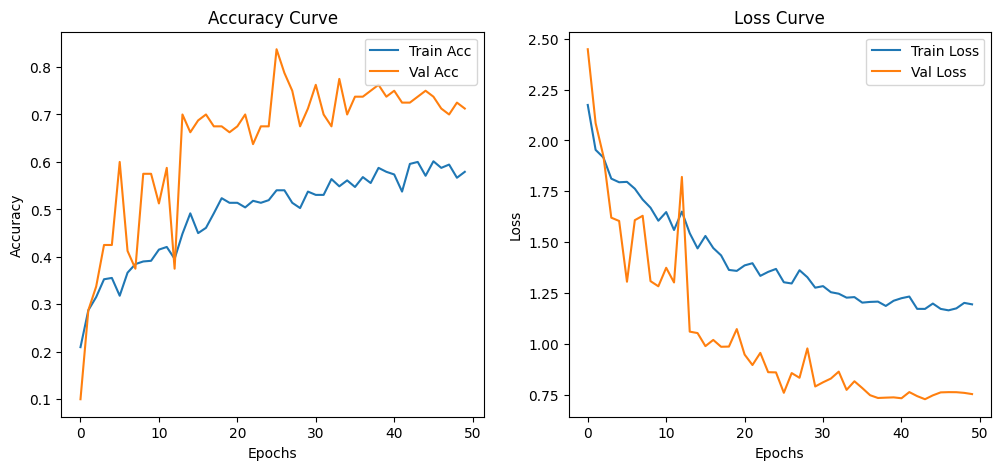


Test Classification Report:
               precision    recall  f1-score   support

       Swarna     0.9576    0.9417    0.9496       120
Katari Siddho     0.5918    0.2417    0.3432       120
        Beroi     0.4315    0.5250    0.4737       120
        BR-29     0.9727    0.8917    0.9304       120
 Katari Najir     0.9571    0.5583    0.7053       120
      Miniket     0.4234    0.9667    0.5888       120
    Chinigura     0.8667    0.3250    0.4727       120
    Ghee Bhog     0.7812    0.6250    0.6944       120
        BR-28     0.7518    0.8833    0.8123       120
         Aush     0.6358    0.8000    0.7085       120

     accuracy                         0.6758      1200
    macro avg     0.7370    0.6758    0.6679      1200
 weighted avg     0.7370    0.6758    0.6679      1200



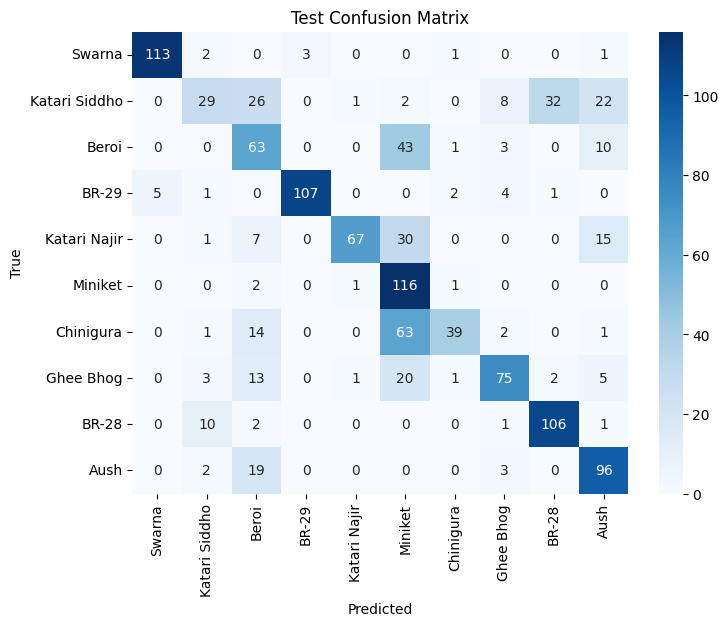

Swarna Accuracy: 0.9417
Katari Siddho Accuracy: 0.2417
Beroi Accuracy: 0.5250
BR-29 Accuracy: 0.8917
Katari Najir Accuracy: 0.5583
Miniket Accuracy: 0.9667
Chinigura Accuracy: 0.3250
Ghee Bhog Accuracy: 0.6250
BR-28 Accuracy: 0.8833
Aush Accuracy: 0.8000

Macro Precision: 0.7370
Macro Recall: 0.6758
Macro F1-score: 0.6679


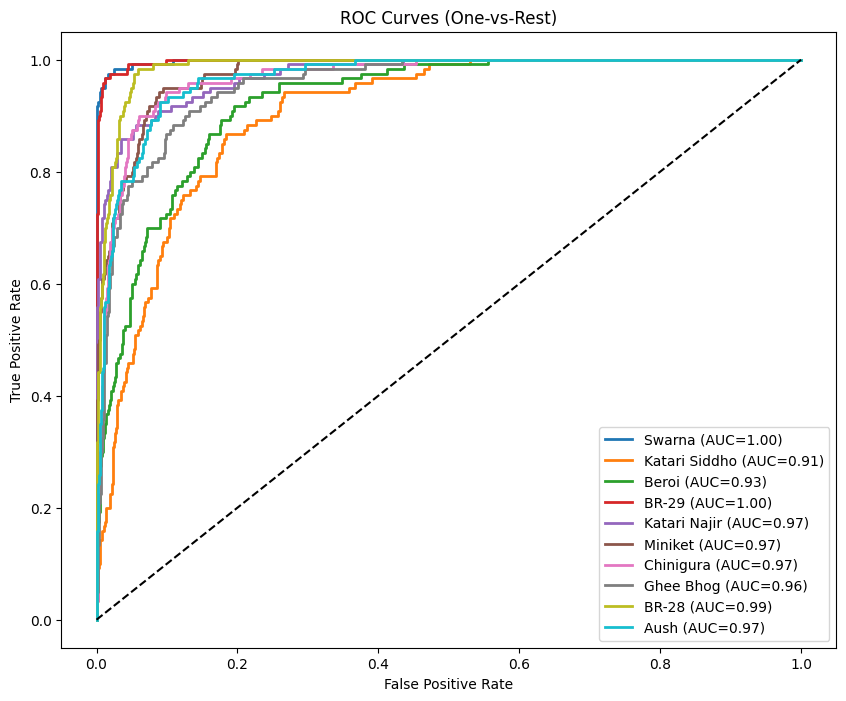

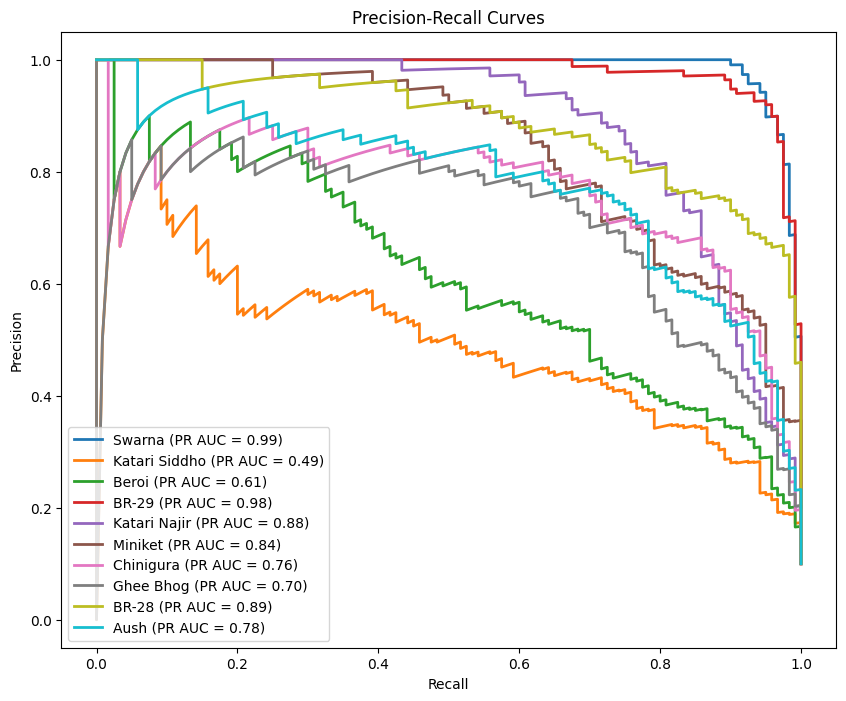


Most confused class pairs:
Swarna is most often confused with BR-29 (3 samples)
Katari Siddho is most often confused with BR-28 (32 samples)
Beroi is most often confused with Miniket (43 samples)
BR-29 is most often confused with Swarna (5 samples)
Katari Najir is most often confused with Miniket (30 samples)
Miniket is most often confused with Beroi (2 samples)
Chinigura is most often confused with Miniket (63 samples)
Ghee Bhog is most often confused with Miniket (20 samples)
BR-28 is most often confused with Katari Siddho (10 samples)
Aush is most often confused with Beroi (19 samples)


In [39]:
#Model-4: ResNet50
import os
import time
import numpy as np
import tensorflow as tf
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score, roc_curve, auc, precision_recall_curve
from sklearn.preprocessing import label_binarize
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

# -----------------------------
# Paths and parameters
# -----------------------------
split_base_dir = '/kaggle/working/split_data'
dataset_dir = "/kaggle/input/processed-rice-varieties-of-bangladesh/PRBD Microscopic Image of Different Processed Rice/Original_Images"
img_size = (224, 224)
batch_size = 16
num_classes = 10
classes = [d for d in os.listdir(dataset_dir) if os.path.isdir(os.path.join(dataset_dir, d))]

# -----------------------------
# Data generators
# -----------------------------
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2]
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    os.path.join(split_base_dir, 'train'),
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

val_gen = val_test_datagen.flow_from_directory(
    os.path.join(split_base_dir, 'val'),
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

test_gen = val_test_datagen.flow_from_directory(
    os.path.join(split_base_dir, 'test'),
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# -----------------------------
# Build fine-tuned ResNet50 model
# -----------------------------
def build_resnet_model(input_shape=(224,224,3), num_classes=10, dropout_rate=0.3, l2_reg=1e-4):
    base_model = ResNet50(include_top=False, weights='imagenet', input_shape=input_shape)
    
    # Fine-tune last 30 layers
    for layer in base_model.layers[:-30]:
        layer.trainable = False
    for layer in base_model.layers[-30:]:
        layer.trainable = True
    
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu', kernel_regularizer=l2(l2_reg))(x)
    x = Dropout(dropout_rate)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=outputs)
    return model

resnet_model = build_resnet_model(num_classes=num_classes)

# -----------------------------
# Compile model
# -----------------------------
resnet_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# -----------------------------
# Callbacks
# -----------------------------
checkpoint = ModelCheckpoint('best_resnet50_model.h5', save_best_only=True, monitor='val_accuracy', mode='max', verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

start_time = time.time()

history = resnet_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=50,
    callbacks=[checkpoint, reduce_lr],
    verbose=2
)

training_time = time.time() - start_time
print(f"\nTotal Training Time: {training_time/60:.2f} minutes")

# -----------------------------
# Plot training curves
# -----------------------------
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# -----------------------------
# Evaluation
# -----------------------------
def evaluate_model(generator, model):
    steps = int(np.ceil(generator.samples / generator.batch_size))
    y_true, y_pred_prob = [], []
    for _ in range(steps):
        x_batch, y_batch = next(generator)
        preds = model.predict(x_batch, verbose=0)
        y_true.append(y_batch)
        y_pred_prob.append(preds)
    y_true = np.vstack(y_true)
    y_pred_prob = np.vstack(y_pred_prob)
    y_pred = np.argmax(y_pred_prob, axis=1)
    y_true_labels = np.argmax(y_true, axis=1)
    return y_true_labels, y_pred, y_true, y_pred_prob

test_true, test_pred, test_true_prob, test_pred_prob = evaluate_model(test_gen, resnet_model)

# -----------------------------
# Reports
# -----------------------------
print("\nTest Classification Report:")
print(classification_report(test_true, test_pred, digits=4, target_names=classes))

cm = confusion_matrix(test_true, test_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=classes, yticklabels=classes, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Test Confusion Matrix')
plt.show()

# -----------------------------
# Metrics
# -----------------------------
per_class_acc = cm.diagonal() / cm.sum(axis=1)
for cls, acc in zip(classes, per_class_acc):
    print(f"{cls} Accuracy: {acc:.4f}")

macro_precision = precision_score(test_true, test_pred, average='macro')
macro_recall = recall_score(test_true, test_pred, average='macro')
macro_f1 = f1_score(test_true, test_pred, average='macro')

print(f"\nMacro Precision: {macro_precision:.4f}")
print(f"Macro Recall: {macro_recall:.4f}")
print(f"Macro F1-score: {macro_f1:.4f}")

# -----------------------------
# ROC–AUC Curves
# -----------------------------
y_true_bin = label_binarize(test_true, classes=range(num_classes))
plt.figure(figsize=(10,8))
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], test_pred_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{classes[i]} (AUC={roc_auc:.2f})')
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves (One-vs-Rest)')
plt.legend(loc='lower right')
plt.show()

# -----------------------------
# PR Curves
# -----------------------------
plt.figure(figsize=(10,8))
for i in range(num_classes):
    precision_vals, recall_vals, _ = precision_recall_curve(y_true_bin[:, i], test_pred_prob[:, i])
    pr_auc = auc(recall_vals, precision_vals)
    plt.plot(recall_vals, precision_vals, lw=2, label=f'{classes[i]} (PR AUC = {pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.legend(loc='lower left')
plt.show()

# -----------------------------
# Confused class pairs
# -----------------------------
cm_df = pd.DataFrame(confusion_matrix(test_true, test_pred), index=classes, columns=classes)
print("\nMost confused class pairs:")
for cls in classes:
    row = cm_df.loc[cls].copy()
    row[cls] = 0
    most_confused = row.idxmax()
    print(f"{cls} is most often confused with {most_confused} ({row.max()} samples)")


In [ ]:
# -----------------------------
# Inference time per sample
# -----------------------------
start_test = time.time()
_ = resnet_model.predict(test_gen, verbose=0)
inference_time = time.time() - start_test
samples = test_gen.samples
print(f"Inference Time per sample: {inference_time/samples:.6f} seconds")


In [43]:
# -----------------------------
# Inference time per sample
# -----------------------------
start_test = time.time()
_ = resnet_model.predict(test_gen, verbose=0)
inference_time = time.time() - start_test
print(f"Inference time per sample: {inference_time/test_gen.samples:.6f} sec")
print(f"Total inference time for {test_gen.samples} samples: {inference_time:.2f} sec")

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Inference time per sample: 0.010550 sec
Total inference time for 1200 samples: 12.66 sec


In [41]:
# -----------------------------
# Model parameters summary
# -----------------------------
total_params = resnet_model.count_params()
trainable_params = sum([tf.keras.backend.count_params(w) for w in resnet_model.trainable_weights])
non_trainable_params = sum([tf.keras.backend.count_params(w) for w in resnet_model.non_trainable_weights])

print(f"Total Parameters: {total_params:,}")
print(f"Trainable Parameters: {trainable_params:,}")
print(f"Non-Trainable Parameters: {non_trainable_params:,}")

Total Parameters: 24,641,930
Trainable Parameters: 15,504,394
Non-Trainable Parameters: 9,137,536


Found 720 images belonging to 10 classes.
Found 80 images belonging to 10 classes.
Found 1200 images belonging to 10 classes.
29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/50
23/23 - 69s - 3s/step - accuracy: 0.4486 - loss: 1.7916 - val_accuracy: 0.7250 - val_loss: 0.8370 - learning_rate: 0.0010
Epoch 2/50
23/23 - 6s - 261ms/step - accuracy: 0.7097 - loss: 0.8386 - val_accuracy: 0.9250 - val_loss: 0.4487 - learning_rate: 0.0010
Epoch 3/50
23/23 - 6s - 266ms/step - accuracy: 0.7833 - loss: 0.6444 - val_accuracy: 0.9250 - val_loss: 0.3529 - learning_rate: 0.0010
Epoch 4/50
23/23 - 6s - 258ms/step - accuracy: 0.8347 - loss: 0.4983 - val_accuracy: 0.9125 - val_loss: 0.3120 - learning_rate: 0.0010
Epoch 5/50
23/23 - 6s - 264ms/step - accuracy: 0.8694 - loss: 0.4330 - val_accuracy: 0.9250 - val_loss: 0.3022 - learning_rate: 0.0010
Epoch 6/50
23/23 - 6s - 261ms/step - accuracy: 0.8931 - loss: 0.3759 - val_accuracy: 0.8750 - val_loss: 0.2876 - learning_rate: 0.0010
Epoch 7/50
23/2

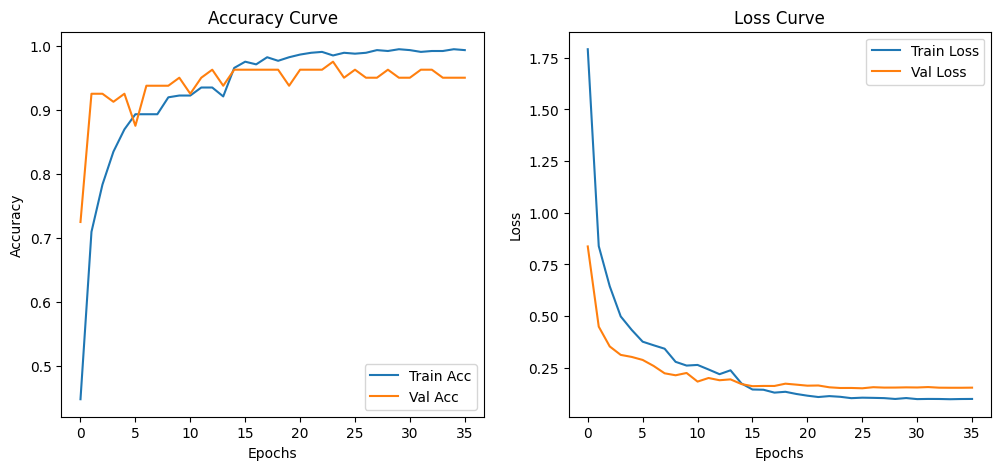


Test Classification Report:
               precision    recall  f1-score   support

       Swarna     0.9915    0.9750    0.9832       120
Katari Siddho     0.8403    0.8333    0.8368       120
        Beroi     0.8981    0.8083    0.8509       120
        BR-29     0.9752    0.9833    0.9793       120
 Katari Najir     0.9669    0.9750    0.9710       120
      Miniket     0.8707    0.8417    0.8559       120
    Chinigura     0.7353    0.8333    0.7812       120
    Ghee Bhog     0.8828    0.9417    0.9113       120
        BR-28     0.9739    0.9333    0.9532       120
         Aush     0.9237    0.9083    0.9160       120

     accuracy                         0.9033      1200
    macro avg     0.9059    0.9033    0.9039      1200
 weighted avg     0.9059    0.9033    0.9039      1200



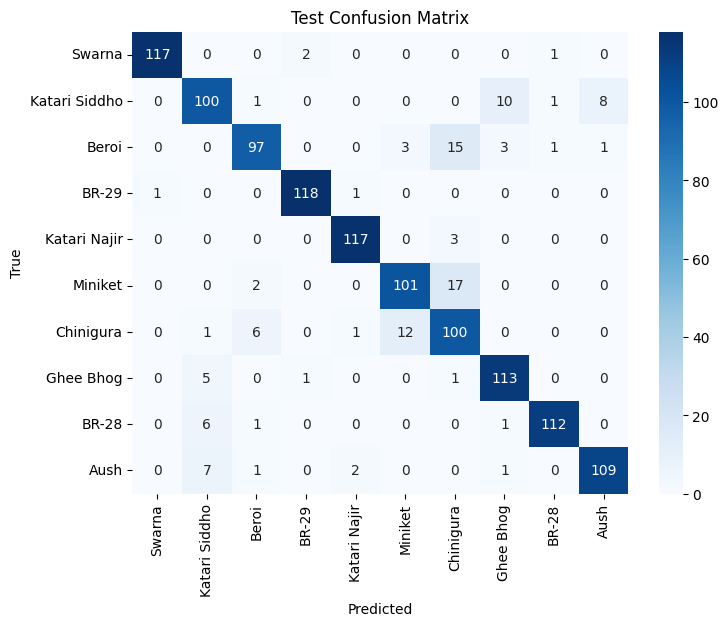

Swarna Accuracy: 0.9750
Katari Siddho Accuracy: 0.8333
Beroi Accuracy: 0.8083
BR-29 Accuracy: 0.9833
Katari Najir Accuracy: 0.9750
Miniket Accuracy: 0.8417
Chinigura Accuracy: 0.8333
Ghee Bhog Accuracy: 0.9417
BR-28 Accuracy: 0.9333
Aush Accuracy: 0.9083


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Total inference time: 30.93 sec
Inference time per sample: 0.025773 sec


In [44]:
# Mode5: DenseNet121

import os
import time
import numpy as np
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# -----------------------------
# Paths and parameters
# -----------------------------
split_base_dir = '/kaggle/working/split_data'
dataset_dir = "/kaggle/input/processed-rice-varieties-of-bangladesh/PRBD Microscopic Image of Different Processed Rice/Original_Images"
img_size = (224, 224)  # DenseNet121 default input
batch_size = 32
num_classes = 10
classes = [d for d in os.listdir(dataset_dir) if os.path.isdir(os.path.join(dataset_dir, d))]

# -----------------------------
# Data generators
# -----------------------------
datagen = ImageDataGenerator(rescale=1./255)

train_gen = datagen.flow_from_directory(
    os.path.join(split_base_dir, 'train'),
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

val_gen = datagen.flow_from_directory(
    os.path.join(split_base_dir, 'val'),
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

test_gen = datagen.flow_from_directory(
    os.path.join(split_base_dir, 'test'),
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# -----------------------------
# Model: DenseNet121
# -----------------------------
def build_densenet_model(input_shape=(224,224,3), num_classes=10, dropout_rate=0.3, l2_reg=1e-4):
    base_model = DenseNet121(include_top=False, weights='imagenet', input_shape=input_shape)
    base_model.trainable = False  # freeze backbone
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu', kernel_regularizer=l2(l2_reg))(x)
    x = Dropout(dropout_rate)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=outputs)
    return model

densenet_model = build_densenet_model(num_classes=num_classes)
densenet_model.compile(optimizer=tf.keras.optimizers.Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# -----------------------------
# Callbacks
# -----------------------------
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)  # increased patience
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

# -----------------------------
# Training
# -----------------------------
start_time = time.time()
history = densenet_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=50,  # increased epochs
    callbacks=[early_stop, reduce_lr],
    verbose=2
)
training_time = time.time() - start_time
print(f"Total training time: {training_time:.2f} sec")

# -----------------------------
# Plot training curves
# -----------------------------
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# -----------------------------
# Evaluation function
# -----------------------------
def evaluate_model(generator, model):
    steps = int(np.ceil(generator.samples / generator.batch_size))
    y_true = []
    y_pred_prob = []
    for _ in range(steps):
        x_batch, y_batch = next(generator)
        preds = model.predict(x_batch, verbose=0)
        y_true.append(y_batch)
        y_pred_prob.append(preds)
    y_true = np.vstack(y_true)
    y_pred_prob = np.vstack(y_pred_prob)
    y_pred = np.argmax(y_pred_prob, axis=1)
    y_true_labels = np.argmax(y_true, axis=1)
    return y_true_labels, y_pred, y_true, y_pred_prob

train_true, train_pred, train_true_prob, train_pred_prob = evaluate_model(train_gen, densenet_model)
val_true, val_pred, val_true_prob, val_pred_prob = evaluate_model(val_gen, densenet_model)
test_true, test_pred, test_true_prob, test_pred_prob = evaluate_model(test_gen, densenet_model)

# -----------------------------
# Reports
# -----------------------------
print("\nTest Classification Report:")
print(classification_report(test_true, test_pred, digits=4, target_names=classes))

cm = confusion_matrix(test_true, test_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=classes, yticklabels=classes, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Test Confusion Matrix')
plt.show()

# Per-class accuracy
per_class_acc = cm.diagonal() / cm.sum(axis=1)
for cls, acc in zip(classes, per_class_acc):
    print(f"{cls} Accuracy: {acc:.4f}")

# -----------------------------
# Testing / Inference time per sample
# -----------------------------
start_infer = time.time()
_ = densenet_model.predict(test_gen, verbose=0)
total_infer_time = time.time() - start_infer
time_per_sample = total_infer_time / test_gen.samples
print(f"Total inference time: {total_infer_time:.2f} sec")
print(f"Inference time per sample: {time_per_sample:.6f} sec")


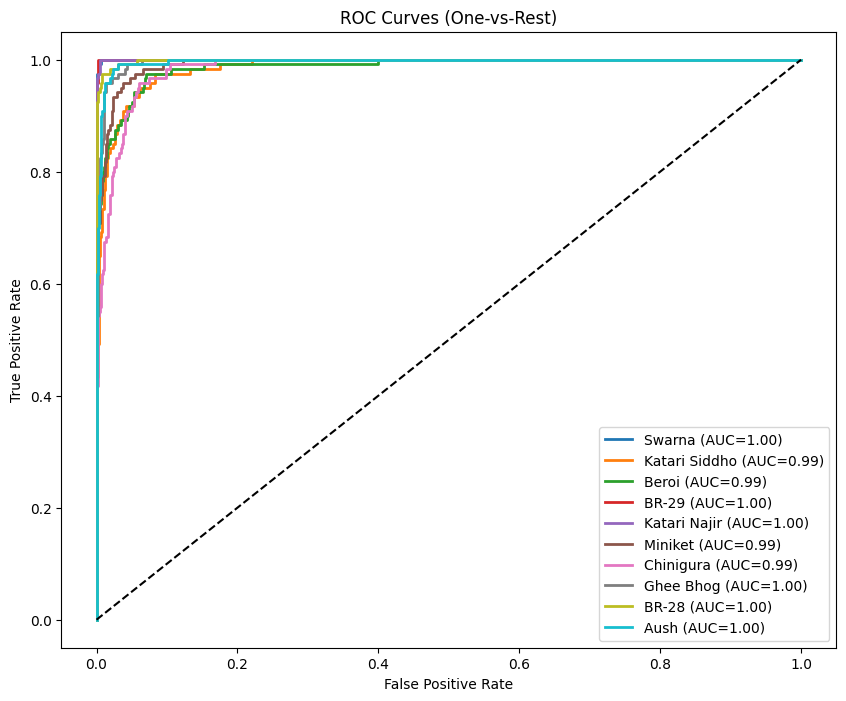

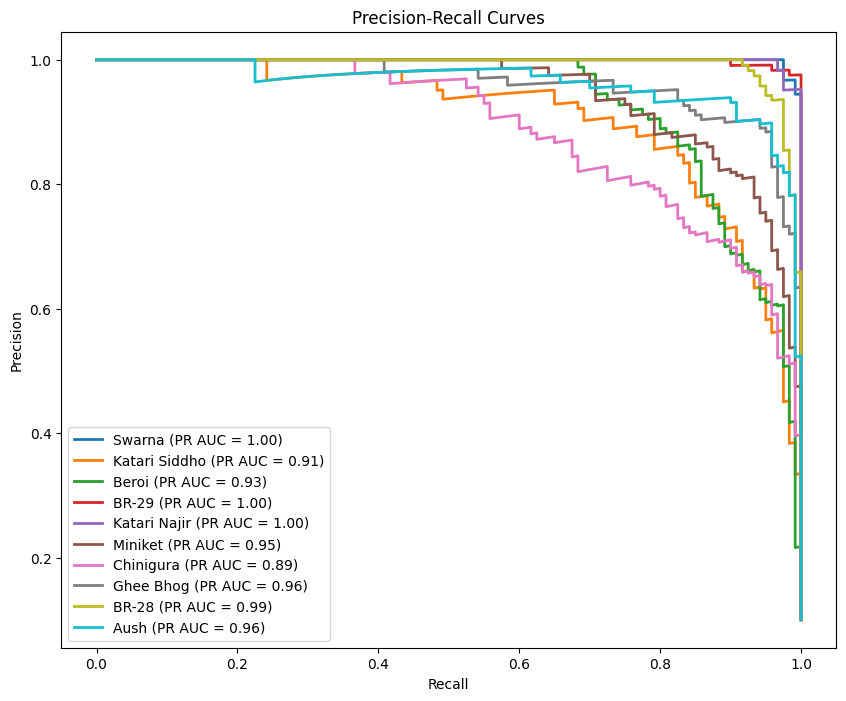


Most confused class pairs:
Swarna is most often confused with BR-29 (2 samples)
Katari Siddho is most often confused with Ghee Bhog (10 samples)
Beroi is most often confused with Chinigura (15 samples)
BR-29 is most often confused with Swarna (1 samples)
Katari Najir is most often confused with Chinigura (3 samples)
Miniket is most often confused with Chinigura (17 samples)
Chinigura is most often confused with Miniket (12 samples)
Ghee Bhog is most often confused with Katari Siddho (5 samples)
BR-28 is most often confused with Katari Siddho (6 samples)
Aush is most often confused with Katari Siddho (7 samples)

Total Training Time: 278.58 sec


In [51]:
 #ROC–AUC curves

y_true_bin = label_binarize(test_true, classes=range(num_classes))
plt.figure(figsize=(10,8))
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], test_pred_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{classes[i]} (AUC={roc_auc:.2f})')
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves (One-vs-Rest)')
plt.legend(loc='lower right')
plt.show()

# -----------------------------
# Precision–Recall curves
# -----------------------------
plt.figure(figsize=(10,8))
for i in range(num_classes):
    precision_vals, recall_vals, _ = precision_recall_curve(y_true_bin[:, i], test_pred_prob[:, i])
    pr_auc = auc(recall_vals, precision_vals)
    plt.plot(recall_vals, precision_vals, lw=2, label=f'{classes[i]} (PR AUC = {pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.legend(loc='lower left')
plt.show()

# -----------------------------
# Most confused class pairs
# -----------------------------
cm_df = pd.DataFrame(cm, index=classes, columns=classes)
print("\nMost confused class pairs:")
for cls in classes:
    row = cm_df.loc[cls].copy()
    row[cls] = 0
    most_confused = row.idxmax()
    print(f"{cls} is most often confused with {most_confused} ({row.max()} samples)")

print(f"\nTotal Training Time: {training_time:.2f} sec")

In [52]:
# -----------------------------
# Inference time per sample
# -----------------------------
start_test = time.time()
_ = densenet_model.predict(test_gen, verbose=0)
inference_time = time.time() - start_test
samples = test_gen.samples
print(f"Inference Time per sample: {inference_time/samples:.6f} seconds")


Inference Time per sample: 0.007568 seconds


In [53]:
# -----------------------------
# Calculate and print model parameters
# -----------------------------
total_params = densenet_model.count_params()
trainable_params = sum([tf.keras.backend.count_params(w) for w in densenet_model.trainable_weights])
non_trainable_params = sum([tf.keras.backend.count_params(w) for w in densenet_model.non_trainable_weights])

print(f"Total Parameters: {total_params:,}")
print(f"Trainable Parameters: {trainable_params:,}")
print(f"Non-Trainable Parameters: {non_trainable_params:,}")

Total Parameters: 7,567,434
Trainable Parameters: 529,930
Non-Trainable Parameters: 7,037,504
